# Showcase 1: Realized Volatility Forecasting

Bucci, A. (2020). Realized volatility forecasting with neural networks. Journal of Financial Econometrics, 18(3), 502-531.

The Model Confidence Set (MCS) proposed by Hansen, Lunde & Nason (2011) attempts to identify the set of models which produce the same expected loss, while controlling the probability that a model that is worse than the best model is in the model confidence set. Like the other MCPs, it controls the Familywise Error Rate rather than the usual test size.


The Quasi-Likelihood (QLIKE) loss function introduced by Patton (2011) is designed to evaluate the accuracy of volatility forecasts. It is considered robust because it gives consistent rankings of different forecasting models, whether using a proxy for volatility or the true volatility.


## Data Load

In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import pandas_datareader.data as web
import pandas_datareader as pdr
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from nolitsa import lyapunov, data

In [3]:
df=pd.read_csv("Data_raw.csv",header=0,index_col=0)

<Axes: xlabel='Date'>

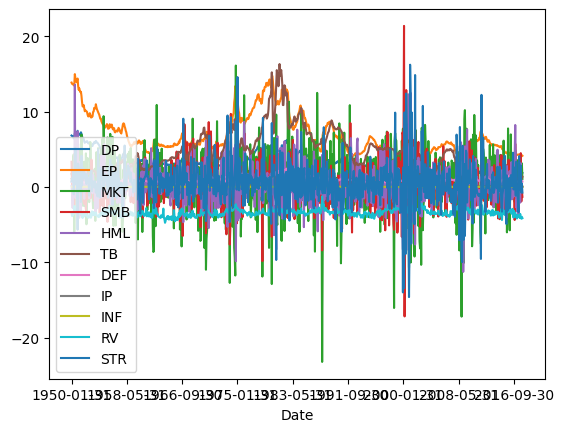

In [4]:
df.plot()

## Chaotic Test on RV

A positive Lyapunov exponent is typically indicative of chaos, signifying sensitive dependence on initial conditions. In contrast, a negative exponent suggests that nearby trajectories in the phase space converge over time, leading to predictable behavior.

In [5]:
def phase_space_reconstruct(series, emb_dim, tau):
    n = len(series)
    if n < (emb_dim - 1) * tau + 1:
        raise ValueError("Time series is too short for the chosen embedding dimension and time delay.")

    reconstructed = np.empty((n - (emb_dim - 1) * tau, emb_dim))
    for i in range(emb_dim):
        reconstructed[:, i] = series[i * tau:n - (emb_dim - 1) * tau + i * tau]

    return reconstructed

# Function to calculate the largest Lyapunov exponent using nolitsa
def calculate_lyapunov_exponent_nolitsa(series, emb_dim=3, tau=2):
    # Reconstruct the phase space
    embedded = phase_space_reconstruct(series, emb_dim, tau)

    # Calculate the Lyapunov exponent
    # The maxt and window parameters may need adjustment depending on your data
    l = lyapunov.mle(embedded, maxt=100, window=10)[0]
    return l

time_series = df['RV'].values

# Calculate the Lyapunov exponent for 'RV'
le_rv = calculate_lyapunov_exponent_nolitsa(time_series)
print("Largest Lyapunov Exponent for 'RV':", le_rv)

Largest Lyapunov Exponent for 'RV': -2.4388582061996713


In [6]:
import numpy as np

def time_delay_embedding(series, embed_dim, tau):
    n_points = len(series) - (embed_dim - 1) * tau
    if n_points <= 0:
        raise ValueError("Time series is too short for the chosen embedding dimension and time delay.")

    reconstructed = np.empty((n_points, embed_dim))
    for i in range(embed_dim):
        reconstructed[:, i] = series[i * tau : i * tau + n_points]

    return reconstructed

# Example usage
time_series = df['RV'].dropna().values  # Replace 'INF' with your time series column

# Set the embedding dimension and time delay
embed_dim = 3
tau = 1

# Perform time delay embedding
embedded_data = time_delay_embedding(time_series, embed_dim, tau)

# Check the shape of the embedded data
print("Shape of embedded_data after embedding:", embedded_data.shape)

# Proceed with the rest of your analysis or plotting


Shape of embedded_data after embedding: (814, 3)


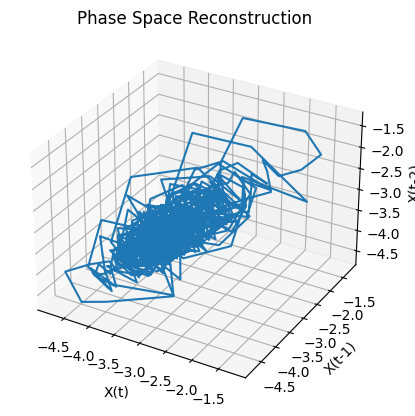

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting the trajectory in the phase space
ax.plot(embedded_data[:, 0], embedded_data[:, 1], embedded_data[:, 2])

ax.set_xlabel('X(t)')
ax.set_ylabel('X(t-1)')
ax.set_zlabel('X(t-2)')

plt.title('Phase Space Reconstruction')
plt.show()


In [8]:
import numpy as np

def zero_one_test(time_series, c=0.9, n=10):
    """
    0-1 Test for chaos in a time series.

    :param time_series: Time series data as a numpy array.
    :param c: A constant typically set between 0 and 2*pi.
    :param n: The number of iterations to average over, more gives better approximations.
    :return: A value close to 0 indicates regular dynamics, close to 1 indicates chaos.
    """
    N = len(time_series)
    p = np.arange(1, N+1)
    theta = p * c

    # Compute K
    K = np.empty(n)
    for j in range(1, n+1):
        # Random phase
        phi = 2 * np.pi * np.random.rand()

        # Translation variables
        x = np.cumsum(time_series * np.cos(theta + phi))
        y = np.cumsum(time_series * np.sin(theta + phi))

        # Mean square displacement
        m = np.mean(x**2 + y**2)

        # Diffusion coefficient
        K[j-1] = m / (N**2)

    # Median of diffusion coefficients
    K_med = np.median(K)

    # 0-1 test statistic
    if K_med > 0.05:
        return 1  # Chaotic
    else:
        return 0  # Regular

# Example usage
# Assuming df is your DataFrame and 'INF' is the column you're analyzing
time_series = df['RV'].dropna().values
test_result = zero_one_test(time_series)
print("0-1 Test result:", test_result)


0-1 Test result: 0


## Unit Root Test for Stationarity

In [9]:
def check_stationarity(data, column):
    """
    Perform Augmented Dickey-Fuller test on a time series.
    Returns the p-value, test statistic, and the critical values.
    """
    result = sm.tsa.adfuller(data.dropna())
    test_statistic = result[0]
    p_value = result[1]
    critical_values = result[4]
    return p_value, test_statistic, critical_values

# Apply the stationarity check for each column in the DataFrame
stationarity_results = {}
for col in df.columns:
    p_value, test_statistic, critical_values = check_stationarity(df[col], col)
    stationarity_results[col] = {'p_value': p_value, 'test_statistic': test_statistic, 'critical_values': critical_values}

# Create a new DataFrame for differenced data
dff = pd.DataFrame(index=df.index)

# Differencing nonstationary variables and adding to dff
for col, results in stationarity_results.items():
    if results['p_value'] > 0.05:  # Assuming nonstationarity if p-value > 0.05
        dff[f'diff_{col}'] = df[col].diff()
    else:
        dff[col] = df[col]

# Display the results of stationarity tests
for col, results in stationarity_results.items():
    print(f"Column: {col}")
    print(f"ADF Statistic: {results['test_statistic']}")
    print(f"p-value: {results['p_value']}")
    for key, value in results['critical_values'].items():
        print(f'Critical Value {key}: {value}')
    print("\n")

# Display the first few rows of the differenced DataFrame
print(dff.head())


Column: DP
ADF Statistic: -2.752722622989024
p-value: 0.06535077209158413
Critical Value 1%: -3.4385197724757233
Critical Value 5%: -2.8651460209504114
Critical Value 10%: -2.5686901720199313


Column: EP
ADF Statistic: -3.694395510031087
p-value: 0.0041926804981727295
Critical Value 1%: -3.4384589869479023
Critical Value 5%: -2.8651192271940693
Critical Value 10%: -2.5686758988725416


Column: MKT
ADF Statistic: -26.390293249392226
p-value: 0.0
Critical Value 1%: -3.438399099271788
Critical Value 5%: -2.8650928286782857
Critical Value 10%: -2.568661836350634


Column: SMB
ADF Statistic: -16.940495754935377
p-value: 9.625622516460507e-30
Critical Value 1%: -3.4384189633001956
Critical Value 5%: -2.86510158480911
Critical Value 10%: -2.568666500743605


Column: HML
ADF Statistic: -24.209134070788142
p-value: 0.0
Critical Value 1%: -3.438399099271788
Critical Value 5%: -2.8650928286782857
Critical Value 10%: -2.568661836350634


Column: TB
ADF Statistic: -2.0172723697575843
p-value: 0.27

In [10]:
def compute_qlike(forecasts, actuals):
    """
    Compute the QLIKE (Quasi-Likelihood) loss function for evaluating forecasting accuracy.
    forecasts: Forecasted variance (sigma squared from a model)
    actuals: Realized variance (actual observed variance)
    """
    # Using absolute values of forecasts and actuals
    forecasts = np.abs(forecasts)
    actuals = np.abs(actuals)

    # Calculate the ratio and ensure it's positive
    ratio = actuals / forecasts

    # Compute QLIKE
    qlike = np.sum(ratio - np.log(ratio) - 1)
    return qlike

In [11]:
#dff=pd.read_csv("dff.csv",header=0,index_col=0)

# Forecast Models

## HAR (Heterogeneous Autoregressive)

 -  HAR model, the model includes the first lag of the variable along with other lagged terms such as weekly and monthly lags (in the context of daily data). For our monthly data, these lagged terms would be the first lag (1-month lag), a quarterly lag (3-month lag), and an annual lag (12-month lag).

 - Estimate the HAR model using a rolling window, keeping the last 245 observations for the testing set.

 - Rolling Window Estimation: For each step in the test set, retrain the model using the most recent data up to that point.

$RV_t = \beta_0 + \beta_1 \times RV_{t-1} + \beta_2 \times RV_{\text{quarterly}, t-1} + \beta_3 \times RV_{\text{annual}, t-1} + \varepsilon_t
$

In [12]:
# Create lagged features
dff['RV_lag1'] = dff['RV'].shift(1)  # First lag (1-month lag)
dff['RV_quarterly_lag'] = dff['RV'].rolling(window=3).mean().shift(1)  # Quarterly lag (average of past 3 months, lagged)
dff['RV_annual_lag'] = dff['RV'].rolling(window=12).mean().shift(1)    # Annual lag (average of past 12 months, lagged)

# dff["RV_lag1"] = dff["RV"].shift(1)
# dff["RV_lag2"] = dff["RV"].shift(2)
# dff["RV_lag3"] = dff["RV"].shift(3)

# Drop NaN values created by lagging and rolling
# dff.dropna(inplace=True)
dff=dff.fillna(0)

# Split into training and testing sets
train = dff.iloc[:-245]
test = dff.iloc[-245:]

# Function to estimate HAR model
def estimate_har_model(data):
    X = data[['RV_lag1', 'RV_quarterly_lag', 'RV_annual_lag']]
    y = data['RV']
    # Adding constant to the model
    model = sm.OLS(y, sm.add_constant(X)).fit()
    return model

In [13]:
# Initialize rolling window
rolling_window_start = 0
rolling_window_end = len(train) - 1

# List for predictions
predictions_har = []

# Rolling window prediction
for t in range(len(test)):
    # Training data for current window
    train_data = dff.iloc[rolling_window_start:rolling_window_end]

    # Fit model
    model = estimate_har_model(train_data)

    # Prepare test data for prediction
    X_test = dff[['RV_lag1', 'RV_quarterly_lag', 'RV_annual_lag']].iloc[rolling_window_end:rolling_window_end+1]
    # Add constant to test data
    X_test = sm.add_constant(X_test, has_constant='add')

    # Predict and store the result
    pred = model.predict(X_test)
    predictions_har.append(pred.values[0])

    # Move rolling window
    rolling_window_start += 1
    rolling_window_end += 1

In [14]:
# Actual values from the test set
actual = test['RV'].values

# Ensure the length of predictions matches the length of the actual test set
predictions_har = predictions_har[-len(actual):]

# Compute MSE
mse = mean_squared_error(actual, predictions_har)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(actual, predictions_har))

# Compute MAE
mae = mean_absolute_error(actual, predictions_har)

# Compute MAPE
mape = np.mean(np.abs((actual - predictions_har) / actual)) * 100

def compute_hit_rate(predictions, actual):
    # Ensure predictions and actuals are numpy arrays
    predictions = np.array(predictions)
    actual = np.array(actual)

    # Convert predictions and actuals to binary movement indicators (1 for increase, 0 for decrease/no change)
    pred_direction = (np.diff(predictions) > 0).astype(int)
    actual_direction = (np.diff(actual) > 0).astype(int)

    # Calculate hit rate
    hits = np.sum(pred_direction == actual_direction)
    hit_rate = hits / len(pred_direction)
    return hit_rate

hit_rate = compute_hit_rate(predictions_har, actual)

print(f"Hit Rate: {hit_rate}")
print(f"Mean Square Error (MSE): {mse}")
print(f"Root Mean Square Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

Hit Rate: 0.4426229508196721
Mean Square Error (MSE): 0.14766711624089768
Root Mean Square Error (RMSE): 0.3842747926170772
Mean Absolute Error (MAE): 0.2980444482393435
Mean Absolute Percentage Error (MAPE): 10.213003624907655%


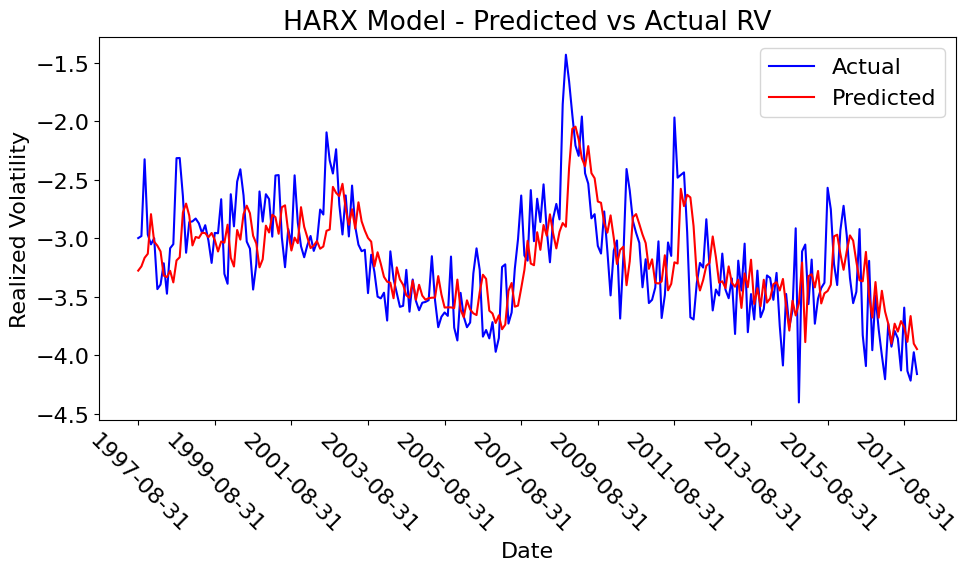

In [15]:
# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.rcParams['font.size'] = 16
plt.plot(test.index, actual, label='Actual', color='blue')
plt.plot(test.index, predictions_har, label='Predicted', color='red')
plt.title('HARX Model - Predicted vs Actual RV')
plt.xlabel('Date')
plt.xticks(test.index[::24],rotation=-45)
plt.ylabel('Realized Volatility')
# plt.text(10, -1.5, 'diff_mean={:.5f}'.format(np.mean(actual-predictions_har)), fontsize=16, color='black', ha='left')
# plt.text(10, -1.75, 'diff_var={:.5f}'.format(np.var(actual-predictions_har)), fontsize=16, color='black', ha='left')
plt.legend()
plt.tight_layout() 
plt.savefig("HAR_model.png")
plt.show()

In [16]:
# Example usage with your data
qlike_loss = compute_qlike(np.array(predictions_har), np.array(actual))
print(f"QLIKE Loss: {qlike_loss}")

QLIKE Loss: 2.0431823800737314


In [17]:
dff.columns

Index(['diff_DP', 'EP', 'MKT', 'SMB', 'HML', 'diff_TB', 'DEF', 'IP', 'INF',
       'RV', 'STR', 'RV_lag1', 'RV_quarterly_lag', 'RV_annual_lag'],
      dtype='object')

## HARX (Heterogeneous Autoregressive model with eXogenous inputs)

- The model includes the first lag of other variables in dff as additional predictors.

$RV_t = \beta_0 + \beta_1 \times RV_{t-1} + \beta_2 \times RV_{\text{quarterly}, t-1} + \beta_3 \times RV_{\text{annual}, t-1} + \sum_{i} (\beta_{i+3} \times X_{i, t-1}) + \varepsilon_t
$



In [18]:
# Assuming dff contains other variables besides 'RV'
other_vars = ['diff_DP', 'MKT', 'STR','DEF'] # dff.columns.drop(['RV','RV_lag2','RV_lag3','RV_lag1', 'RV_quarterly_lag', 'RV_annual_lag'])#['diff_DP', 'MKT', 'STR','DEF']#dff.columns.drop('RV')

# Create first lag for other variables
for var in other_vars:
    dff[f'{var}_lag1'] = dff[var].shift(1)

# Function to estimate HARX model
def estimate_harx_model(data, additional_vars):
    X = data[['RV_lag1', 'RV_quarterly_lag', 'RV_annual_lag'] + additional_vars]
    y = data['RV']
    # Adding constant to the model
    model = sm.OLS(y, sm.add_constant(X)).fit()
    return model

# Drop NaN values created by lagging and rolling
# dff.dropna(inplace=True)
dff = dff.fillna(0)

# Split into training and testing sets
train = dff.iloc[:-245]
test = dff.iloc[-245:]

# List of additional lagged variables
additional_vars = [f'{var}_lag1' for var in other_vars]

In [19]:
# Initialize rolling window
rolling_window_start = 277
rolling_window_end = len(train) - 1

# List for predictions
predictions_harx = []

# Rolling window prediction
for t in range(len(test)):
    # Training data for current window
    train_data = dff.iloc[rolling_window_start:rolling_window_end]

    # Fit HARX model
    model = estimate_harx_model(train_data, additional_vars)

    # Prepare test data for prediction
    X_test = dff[['RV_lag1', 'RV_quarterly_lag', 'RV_annual_lag'] + additional_vars].iloc[rolling_window_end:rolling_window_end+1]
    # Add constant to test data
    X_test = sm.add_constant(X_test, has_constant='add')

    # Predict and store the result
    pred = model.predict(X_test)
    predictions_harx.append(pred.values[0])

    # Move rolling window
    rolling_window_start += 1
    rolling_window_end += 1

In [20]:
# Actual values from the test set
actual = test['RV'].values

# Ensure the length of predictions matches the length of the actual test set
predictions_harx = predictions_harx[-len(actual):]

# Compute MSE
mse = mean_squared_error(actual, predictions_harx)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(actual, predictions_harx))

# Compute MAE
mae = mean_absolute_error(actual, predictions_harx)

# Compute MAPE
mape = np.mean(np.abs((actual - predictions_harx) / actual)) * 100
hit_rate = compute_hit_rate(predictions_har, actual)

print(f"Hit Rate: {hit_rate}")
print(f"Mean Square Error (MSE): {mse}")
print(f"Root Mean Square Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

Hit Rate: 0.4426229508196721
Mean Square Error (MSE): 0.1465684974255853
Root Mean Square Error (RMSE): 0.3828426536131852
Mean Absolute Error (MAE): 0.2931510394369178
Mean Absolute Percentage Error (MAPE): 10.053479061289462%


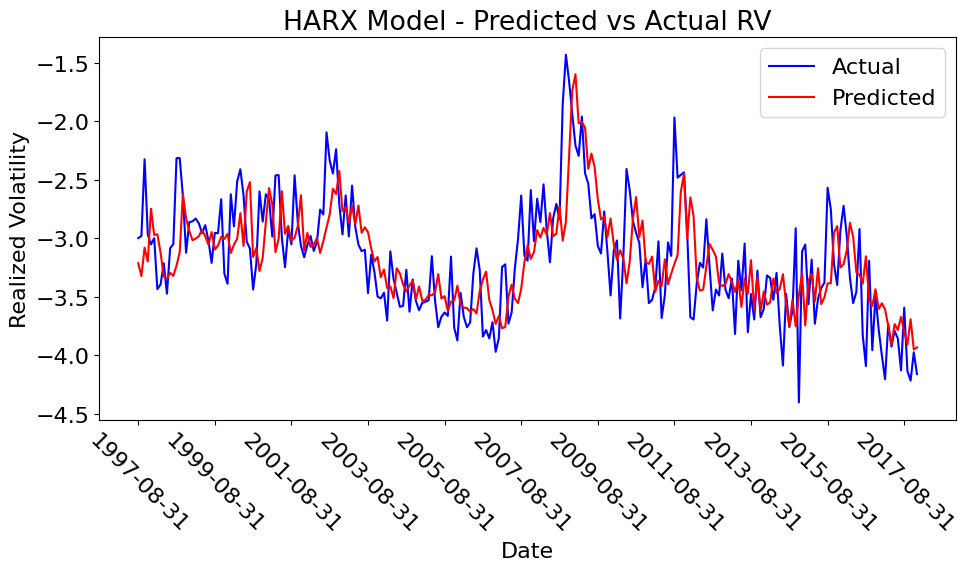

In [21]:
# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.rcParams['font.size'] = 16
plt.plot(test.index, actual, label='Actual', color='blue')
plt.plot(test.index, predictions_harx, label='Predicted', color='red')
plt.title('HARX Model - Predicted vs Actual RV')
plt.xlabel('Date')
plt.xticks(test.index[::24],rotation=-45)
plt.ylabel('Realized Volatility')
# plt.text(10, -1.5, 'diff_mean={:.5f}'.format(np.mean(actual-predictions_harx)), fontsize=16, color='black', ha='left')
# plt.text(10, -1.75, 'diff_var={:.5f}'.format(np.var(actual-predictions_harx)), fontsize=16, color='black', ha='left')
plt.legend()
plt.tight_layout() 
plt.savefig("HARX_model.png")
plt.show()

In [22]:
# Example usage with your data
qlike_loss = compute_qlike(np.array(predictions_harx), np.array(actual))
print(f"QLIKE Loss: {qlike_loss}")


QLIKE Loss: 2.083494880705304


## AR(1) and AR(3)

In [23]:
dff.index = pd.DatetimeIndex(dff.index).to_period('M')

def rolling_forecast_ar(data, order, train_size):
    predictions = []
    for end in range(train_size, len(data)):
        train_data = data[:end]
        model = AutoReg(train_data, lags=order, old_names=False)
        model_fit = model.fit()
        pred = model_fit.predict(start=len(train_data), end=len(train_data), dynamic=False)
        predictions.append(pred.iloc[0])
    actual = data[train_size:]
    return predictions, actual

def compute_metrics(predictions, actual):
    mse = mean_squared_error(actual, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predictions)
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    return mse, rmse, mae, mape

def compute_hit_rate(predictions, actual):
    predictions = np.array(predictions)
    actual = np.array(actual)
    pred_direction = (np.diff(predictions) > 0).astype(int)
    actual_direction = (np.diff(actual) > 0).astype(int)
    hits = np.sum(pred_direction == actual_direction)
    hit_rate = hits / len(pred_direction)
    return hit_rate

# Assuming 'dff' is your DataFrame and 'RV' is the target variable
series = dff['RV'].dropna()

# Training set size
train_size = len(dff) - 245

# AR(1) Model
predictions_ar1, actual_ar1 = rolling_forecast_ar(series, 1, train_size)

# AR(3) Model
predictions_ar3, actual_ar3 = rolling_forecast_ar(series, 3, train_size)

# Compute Metrics for AR(1)
mse_ar1, rmse_ar1, mae_ar1, mape_ar1 = compute_metrics(predictions_ar1, actual_ar1)
hit_rate_ar1 = compute_hit_rate(predictions_ar1, actual_ar1)

# Compute Metrics for AR(3)
mse_ar3, rmse_ar3, mae_ar3, mape_ar3 = compute_metrics(predictions_ar3, actual_ar3)
hit_rate_ar3 = compute_hit_rate(predictions_ar3, actual_ar3)

# Print the metrics
print("AR(1) Model Metrics:")
print(f"Hit Rate: {hit_rate_ar1}")
print(f"Mean Square Error (MSE): {mse_ar1}")
print(f"Root Mean Square Error (RMSE): {rmse_ar1}")
print(f"Mean Absolute Error (MAE): {mae_ar1}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_ar1}%")

print("\nAR(3) Model Metrics:")
print(f"Hit Rate: {hit_rate_ar3}")
print(f"Mean Square Error (MSE): {mse_ar3}")
print(f"Root Mean Square Error (RMSE): {rmse_ar3}")
print(f"Mean Absolute Error (MAE): {mae_ar3}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_ar3}%")


AR(1) Model Metrics:
Hit Rate: 0.38934426229508196
Mean Square Error (MSE): 0.13048886541389876
Root Mean Square Error (RMSE): 0.3612324257509267
Mean Absolute Error (MAE): 0.2751996553113105
Mean Absolute Percentage Error (MAPE): 9.38442177022576%

AR(3) Model Metrics:
Hit Rate: 0.38524590163934425
Mean Square Error (MSE): 0.11785214314545148
Root Mean Square Error (RMSE): 0.34329599931466065
Mean Absolute Error (MAE): 0.2642466981986571
Mean Absolute Percentage Error (MAPE): 8.986876314961942%


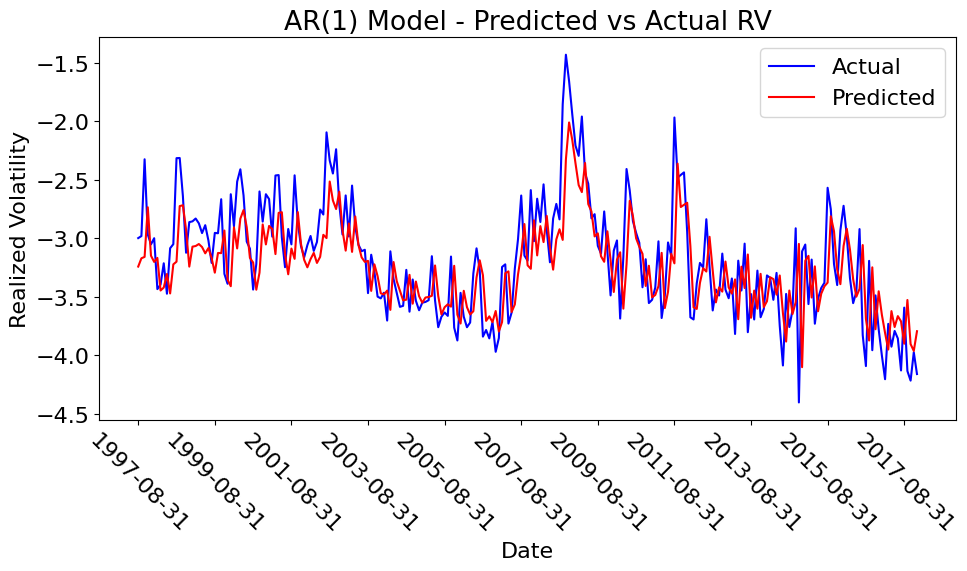

In [24]:
# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.rcParams['font.size'] = 16
plt.plot(test.index, actual, label='Actual', color='blue')
plt.plot(test.index, predictions_ar1, label='Predicted', color='red')
plt.title('AR(1) Model - Predicted vs Actual RV')
plt.xlabel('Date')
plt.xticks(test.index[::24],rotation=-45)
plt.ylabel('Realized Volatility')
# plt.text(10, -1.5, 'diff_mean={:.5f}'.format(np.mean(actual-predictions_ar1)), fontsize=16, color='black', ha='left')
# plt.text(10, -1.75, 'diff_var={:.5f}'.format(np.var(actual-predictions_ar1)), fontsize=16, color='black', ha='left')
plt.legend()
plt.tight_layout() 
plt.savefig("AR(1)_model.png")
plt.show()

In [25]:
# Example usage with your data
qlike_loss = compute_qlike(np.array(predictions_ar1), np.array(actual))
print(f"QLIKE Loss: {qlike_loss}")

QLIKE Loss: 1.7279255035816639


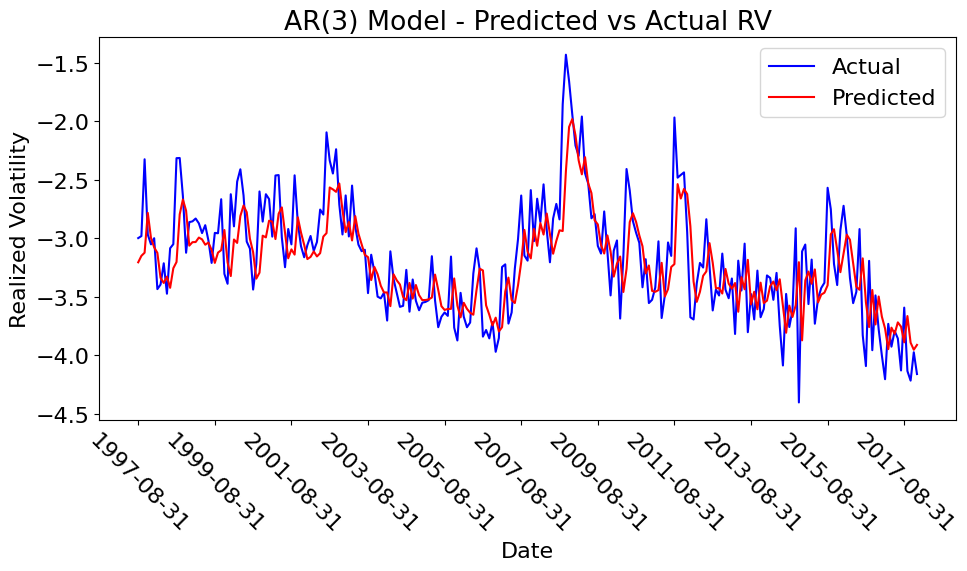

In [26]:
# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.rcParams['font.size'] = 16
plt.plot(test.index, actual, label='Actual', color='blue')
plt.plot(test.index, predictions_ar3, label='Predicted', color='red')
plt.title('AR(3) Model - Predicted vs Actual RV')
plt.xlabel('Date')
plt.xticks(test.index[::24],rotation=-45)
plt.ylabel('Realized Volatility')
# plt.text(10, -1.5, 'diff_mean={:.5f}'.format(np.mean(actual-predictions_ar3)), fontsize=16, color='black', ha='left')
# plt.text(10, -1.75, 'diff_var={:.5f}'.format(np.var(actual-predictions_ar3)), fontsize=16, color='black', ha='left')
plt.legend()
plt.tight_layout() 
plt.savefig("AR(3)_model.png")
plt.show()

In [27]:
# Example usage with your data
qlike_loss = compute_qlike(np.array(predictions_ar3), np.array(actual))
print(f"QLIKE Loss: {qlike_loss}")

QLIKE Loss: 1.5893102400532686


our MCS analysis results suggest the following:

Model 3 is the only model included in the Model Confidence Set. This is indicated by its p-value of 1.0000, which implies that it comfortably fits within the set of best-performing models.

The other models (0, 1, and 2) are excluded from the MCS. Their p-values (0.0060 for models 0 and 2, and 0.0045 for model 1) are all below the typical significance threshold (e.g., 0.05), indicating that these models are statistically different from the best-performing model in terms of forecasting performance.

In summary, Model 3 is the top performer among the models you tested, while the others do not perform as well in comparison, based on the chosen loss function and the MCS methodology.

In the context of the Model Confidence Set (MCS) analysis, bootstrapping does not typically involve re-estimating the models multiple times. Instead, it uses the predicted values from the main model(s) and applies resampling techniques to these predictions. The essence of bootstrapping here is to create many synthetic samples (reps) from the original dataset by resampling with replacement. The MCS procedure then uses these samples to evaluate the stability and robustness of the model performance measures (like loss functions) across different simulated scenarios. This approach helps in assessing the statistical significance of the model performance differences.

## ARMAX

In [28]:
def rolling_forecast_armax(data, exog_data, order, train_size):
    predictions = []
    for end in range(train_size, len(data)):
        train_data = data[:end]
        exog_train = exog_data[:end]
        model = ARIMA(train_data, order=order, exog=exog_train, trend='n')
        model_fit = model.fit(method_kwargs={"warn_convergence": False})
        exog_test = exog_data.iloc[end:end+1]
        pred = model_fit.forecast(exog=exog_test)
        predictions.append(pred.iloc[0])
    actual = data[train_size:]
    return predictions, actual

def compute_metrics(predictions, actual):
    mse = mean_squared_error(actual, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predictions)
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    return mse, rmse, mae, mape

def compute_hit_rate(predictions, actual):
    predictions = np.array(predictions)
    actual = np.array(actual)
    pred_direction = (np.diff(predictions) > 0).astype(int)
    actual_direction = (np.diff(actual) > 0).astype(int)
    hits = np.sum(pred_direction == actual_direction)
    hit_rate = hits / len(pred_direction)
    return hit_rate

# Prepare DataFrame
#dff.index = pd.DatetimeIndex(dff.index).to_period('M')

# Creating lagged exogenous variables
exog_vars = dff.drop(columns=['RV']).shift(1).dropna()

# Target variable
series = dff['RV'].dropna()

# Aligning series and exog_vars by index
series, exog_vars = series.align(exog_vars, join='inner')

# Training set size
train_size = len(series) - 245

# ARMAX Model (with AR(1))
order = (1, 0, 0)
predictions_armax, actual_armax = rolling_forecast_armax(series, exog_vars, order, train_size)

# Compute Metrics for ARMAX
mse_armax, rmse_armax, mae_armax, mape_armax = compute_metrics(predictions_armax, actual_armax)
hit_rate_armax = compute_hit_rate(predictions_armax, actual_armax)

# Print the metrics for ARMAX
print("ARMAX Model Metrics:")
print(f"Hit Rate: {hit_rate_armax}")
print(f"Mean Square Error (MSE): {mse_armax}")
print(f"Root Mean Square Error (RMSE): {rmse_armax}")
print(f"Mean Absolute Error (MAE): {mae_armax}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_armax}%")

ARMAX Model Metrics:
Hit Rate: 0.430327868852459
Mean Square Error (MSE): 0.11952038948083749
Root Mean Square Error (RMSE): 0.34571721027573604
Mean Absolute Error (MAE): 0.2690760586545395
Mean Absolute Percentage Error (MAPE): 8.826275588786359%


In [29]:
# mse_armax, rmse_armax, mae_armax, mape_armax = compute_metrics(predictions_qr2, actual_armax)
# print("QR2 Model Metrics:")
# print(f"Hit Rate: {hit_rate_armax}")
# print(f"Mean Square Error (MSE): {mse_armax}")
# print(f"Root Mean Square Error (RMSE): {rmse_armax}")
# print(f"Mean Absolute Error (MAE): {mae_armax}")
# print(f"Mean Absolute Percentage Error (MAPE): {mape_armax}%")

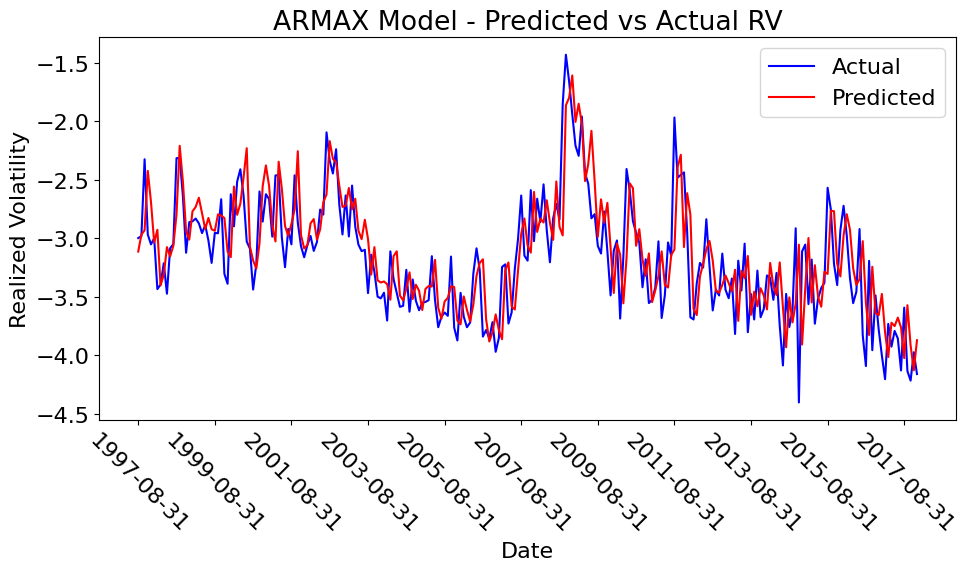

In [30]:
# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.rcParams['font.size'] = 16
plt.plot(test.index, actual, label='Actual', color='blue')
plt.plot(test.index, predictions_armax, label='Predicted', color='red')
plt.title('ARMAX Model - Predicted vs Actual RV')
plt.xlabel('Date')
plt.xticks(test.index[::24],rotation=-45)
plt.ylabel('Realized Volatility')
# plt.text(10, -1.5, 'diff_mean={:.5f}'.format(np.mean(actual-predictions_armax)), fontsize=16, color='black', ha='left')
# plt.text(10, -1.75, 'diff_var={:.5f}'.format(np.var(actual-predictions_armax)), fontsize=16, color='black', ha='left')
plt.legend()
plt.tight_layout() 
plt.savefig("ARMAX_model.png")
plt.show()

In [31]:
# Example usage with your data
qlike_loss = compute_qlike(np.array(predictions_armax), np.array(actual))
print(f"QLIKE Loss: {qlike_loss}")

QLIKE Loss: 1.6341795073904082


In [32]:
QR_all_pred = pd.read_csv("predict_result.csv",header=0,index_col=False)
predictions_qr1 = QR_all_pred["QR1"]
predictions_qr2 = QR_all_pred["QR2"]

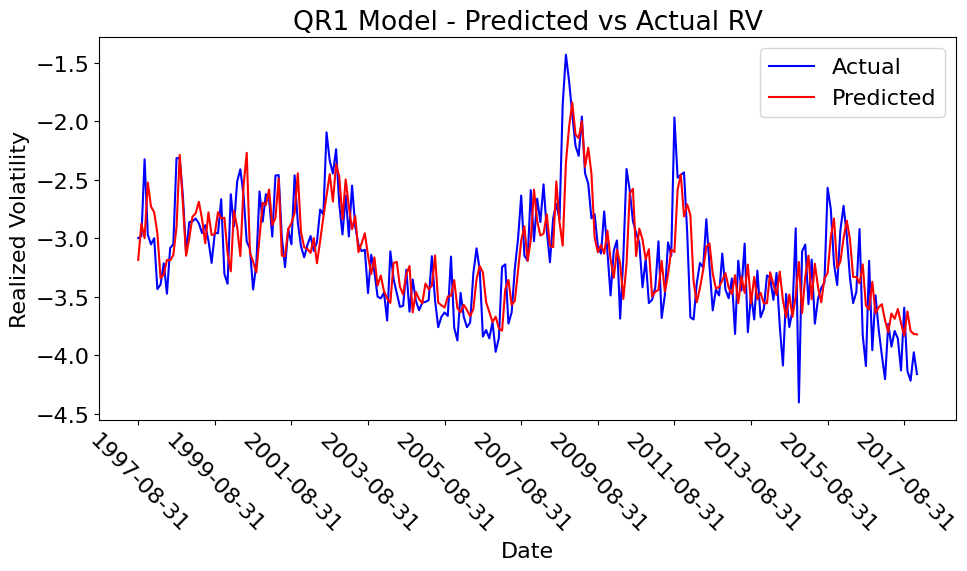

In [33]:
# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.rcParams['font.size'] = 16
plt.plot(test.index, actual, label='Actual', color='blue')
plt.plot(test.index, predictions_qr1, label='Predicted', color='red')
plt.title('QR1 Model - Predicted vs Actual RV')
plt.xlabel('Date')
plt.xticks(test.index[::24],rotation=-45)
plt.ylabel('Realized Volatility')
# plt.text(10, -1.5, 'diff_mean={:.5f}'.format(np.mean(actual-predictions_qr1)), fontsize=16, color='black', ha='left')
# plt.text(10, -1.75, 'diff_var={:.5f}'.format(np.var(actual-predictions_qr1)), fontsize=16, color='black', ha='left')
plt.legend()
plt.tight_layout() 
plt.savefig("QR1_model.png")
plt.show()

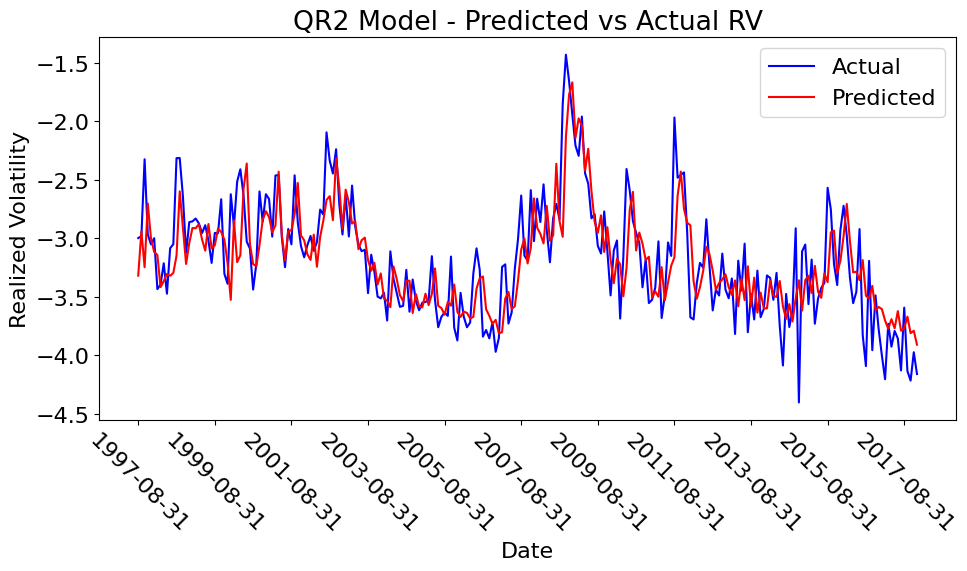

In [34]:
# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.rcParams['font.size'] = 16
plt.plot(test.index, actual, label='Actual', color='blue')
plt.plot(test.index, predictions_qr2, label='Predicted', color='red')
plt.title('QR2 Model - Predicted vs Actual RV')
plt.xlabel('Date')
plt.xticks(test.index[::24],rotation=-45)
plt.ylabel('Realized Volatility')
# plt.text(10, -1.5, 'diff_mean={:.5f}'.format(np.mean((actual-predictions_qr2))), fontsize=16, color='black', ha='left')
# plt.text(10, -1.75, 'diff_var={:.5f}'.format(np.var(actual-predictions_qr2)), fontsize=16, color='black', ha='left')
plt.legend()
plt.tight_layout() 
plt.savefig("QR2_model.png")
plt.show()

In [35]:
predictions_lstm = np.loadtxt("LSTM/lstm60_predictions.csv",delimiter=',')
predictions_lstmx = np.loadtxt("LSTM/lstmx50_predictions.csv",delimiter=',')
predictions_crl = np.loadtxt("Classical_Reservoir_learning/best_CRL(50)_predictions.csv",delimiter=',')
predictions_crlx = np.loadtxt("Classical_Reservoir_learning/best_CRLX(20)_predictions.csv",delimiter=',')

In [36]:
from arch.bootstrap import MCS

# Assuming actual is the array of actual values

# Calculate losses for both models
har_loss = (predictions_har - actual) ** 2  # MSE for HAR
harx_loss = (predictions_harx - actual) ** 2  # MSE for HARX
ar1_loss = (predictions_ar1 - actual) ** 2  # MSE for AR1
ar3_loss = (predictions_ar3 - actual) ** 2  # MSE for AR3
qr1_loss = (predictions_qr1 - actual) ** 2  # MSE for AR3
qr2_loss = (predictions_qr2 - actual) ** 2  # MSE for AR3
armax_loss = (predictions_armax - actual) ** 2  # MSE for AR3
lstm_loss = (predictions_lstm - actual) ** 2
lstmx_loss = (predictions_lstmx - actual) ** 2
crl_loss = (predictions_crl - actual) ** 2
crlx_loss = (predictions_crlx - actual) ** 2

# Combine losses into a single array
losses = np.column_stack([har_loss, harx_loss, ar1_loss, ar3_loss, qr1_loss,qr2_loss, armax_loss, lstm_loss, lstmx_loss, crl_loss, crlx_loss])

# Initialize MCS
mcs = MCS(losses, size=0.05, reps=10000, method='R', bootstrap='stationary')

# Compute MCS
mcs.compute()

# Check which models are included in the MCS
print('Included models:', mcs.included)

# Get p-values for the models
p_values = mcs.pvalues

# Print p-values
print('P-values for included models:', p_values)

Included models: [3, 4, 5, 6, 8, 10]
P-values for included models:              Pvalue
Model index        
0            0.0021
2            0.0037
1            0.0072
9            0.0072
7            0.0195
10           0.0557
3            0.0672
6            0.1067
8            0.3279
4            0.7542
5            1.0000


In [37]:
np.mean((predictions_crlx-actual)**2)

0.16089804610541703

In [38]:
compute_qlike(np.array(predictions_crlx), np.array(actual))

2.254261096371811

In [39]:
# Calculate losses for both models
har_qloss = (np.abs(actual)/np.abs(predictions_har)-np.log(np.abs(actual)/np.abs(predictions_har))-1)  # MSE for HAR
harx_qloss = (np.abs(actual)/np.abs(predictions_harx)-np.log(np.abs(actual)/np.abs(predictions_harx))-1)  # MSE for HARX
ar1_qloss = (np.abs(actual)/np.abs(predictions_ar1)-np.log(np.abs(actual)/np.abs(predictions_ar1))-1)  # MSE for HARX
ar3_qloss = (np.abs(actual)/np.abs(predictions_ar3)-np.log(np.abs(actual)/np.abs(predictions_ar3))-1)  # MSE for HARX
qr1_qloss = (np.abs(actual)/np.abs(predictions_qr1)-np.log(np.abs(actual)/np.abs(predictions_qr1))-1)  # MSE for HARX
qr2_qloss = (np.abs(actual)/np.abs(predictions_qr2)-np.log(np.abs(actual)/np.abs(predictions_qr2))-1)  # MSE for HARX
armax_qloss = (np.abs(actual)/np.abs(predictions_armax)-np.log(np.abs(actual)/np.abs(predictions_armax))-1)  # MSE for HARX

lstm_qloss = (np.abs(actual)/np.abs(predictions_lstm)-np.log(np.abs(actual)/np.abs(predictions_lstm))-1)  # MSE for HARX
lstmx_qloss = (np.abs(actual)/np.abs(predictions_lstmx)-np.log(np.abs(actual)/np.abs(predictions_lstmx))-1)  # MSE for HARX
crl_qloss = (np.abs(actual)/np.abs(predictions_crl)-np.log(np.abs(actual)/np.abs(predictions_crl))-1)  # MSE for HARX
crlx_qloss = (np.abs(actual)/np.abs(predictions_crlx)-np.log(np.abs(actual)/np.abs(predictions_crlx))-1)  # MSE for HARX

# Combine losses into a single array
lossesq = np.column_stack([har_qloss, harx_qloss, ar1_qloss, ar3_qloss, qr1_qloss,qr2_qloss, armax_qloss, lstm_qloss, lstmx_qloss, crl_qloss, crlx_qloss])

# Initialize MCS
mcsq = MCS(losses, size=0.05, reps=10000, method='R', bootstrap='stationary')

# Compute MCS
mcsq.compute()

# Check which models are included in the MCS
print('Included models:', mcsq.included)

# Get p-values for the models
p_valuesq = mcsq.pvalues

# Print p-values
print('P-values for included models:', p_valuesq)

Included models: [3, 4, 5, 6, 8, 10]
P-values for included models:              Pvalue
Model index        
0            0.0037
2            0.0065
1            0.0084
9            0.0084
7            0.0195
10           0.0593
3            0.0672
6            0.1118
8            0.3197
4            0.7511
5            1.0000


In [40]:
f=['har','harx']

In [41]:
p_valuesq.index

Index([0, 2, 1, 9, 7, 10, 3, 6, 8, 4, 5], dtype='int64', name='Model index')

In [42]:
from scipy.stats import t

def diebold_mariano_test(actual, pred1, pred2):
    """
    Conduct the Diebold-Mariano test for two sets of predictions.

    :param actual: The actual values
    :param pred1: The first set of predictions
    :param pred2: The second set of predictions
    :return: DM test statistic and p-value
    """
    # Forecast errors
    e1 = actual - pred1
    e2 = actual - pred2

    # Loss differential
    d = np.square(e1) - np.square(e2)

    # Mean and variance of loss differential
    mean_d = np.mean(d)
    var_d = np.var(d, ddof=1) / len(d)

    # DM Test statistic
    dm_stat = mean_d / np.sqrt(var_d)
    p_value = 2 * t.cdf(-abs(dm_stat), df=len(d) - 1)

    return dm_stat, p_value

# Assuming predictions_har and predictions_harx are your predictions from HAR and HARX models
pre=[predictions_qr1,predictions_qr2,predictions_har,predictions_harx,predictions_ar3,predictions_ar1,predictions_armax,predictions_lstm,predictions_lstmx,predictions_crl,predictions_crlx]
dm_stat, p_value = diebold_mariano_test(actual, predictions_har, predictions_harx)
print(dm_stat)

0.2570211871652455


In [43]:
dm_stat=np.zeros((11,11))
p_value = np.zeros((11,11))

In [44]:
for i in range(11):
    for j in range(i+1,11):
       dm_stat[i,j], p_value[i,j] = diebold_mariano_test(actual, pre[i], pre[j]) 

In [45]:
np.savetxt("dm_stat.csv",dm_stat,delimiter=',', fmt='%3f')

In [46]:
np.savetxt("p_value.csv",p_value,delimiter=',', fmt='%3f')